In [14]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ieee_isc2_2020.mplstyle")

In [5]:
def read_results(city, sim_run_mode, sim_scenario_name, filename, file_format):

    results_path = os.path.join(
        "/home/bigdata-01QYD/s261423/my_e3f2s_folder/e3f2s/e3f2s/simulator/results",
        city,
        sim_run_mode,
        sim_scenario_name,
    )
    

    if file_format == "csv":
        df = pd.read_csv(
            os.path.join(
                results_path,
                ".".join([filename, file_format])
            ), index_col=0
        )
    elif file_format == "pickle":
        df = pd.read_pickle(
            os.path.join(
                results_path,
                ".".join([filename, file_format])
            )
        )
            
    return df

In [6]:
cities = [
   "Torino"
]

relocation_strategies = {
    "no_relocation": "no_relocation",
    "magic_relocation": "magic_relocation"
}

#avg_scooter_speed = 10  # km/h
avg_relocation_speed = 20  # km/h

#vehicle_cost = 360  # $

relocation_vehicle_cost_advance = 10000  # $
relocation_vehicle_cost_per_month = 400  # $/month
relocation_vehicle_consumption = 7  # l/100km

diesel_price = 0.65  # $/l (USA)
relocation_vehicle_per_km_cost = relocation_vehicle_consumption * diesel_price

worker_cost = 18  # $/h

unlock_fee = 1  # $
rent_fee = 0.15  # $/min

administrative_cost_conf = {
    "relocation_workers_hourly_cost": 23,   
}

scenario_cost_conf = {

    "real_bookings_fraction": 1,
    "price_per_minute": 0.20,
    "utilization_relocation_workers" : 1,
    "kwh_cost": 0.19,

}

poles_cost_conf = {

    "pole_useful_life": 10,
    "pole_hardware_cost": 1700, 
    "pole_labor_cost": 2200, 
    "pole_annual_mantenaince_cost": 500, 
    "cosap_annual_tax": 355, 
    "zone_makeready_cost":  1500, 

}

vehicles_cost_conf = {

    "annual_leasing_cost": 4000, 
    "washing_cost": 8, 
    "disinfection_cost": 15, 

}

In [7]:
sim_stats_df_dict = dict()
for city in cities:
    sim_stats_df_dict[city] = dict()
    for strategy in relocation_strategies:
        sim_stats_df_dict[city][strategy] = pd.DataFrame()
        for n_relocation_workers in range(3,13):
            df = read_results(city, 'multiple_runs', relocation_strategies[strategy], "sim_stats", "csv")

            # Initial Investment

            df["vehicles_cost"] = \
                df["n_vehicles_sim"] * vehicles_cost_conf['annual_leasing_cost'] / 12
            
            df['poles_cost'] = (df["tot_n_charging_poles"]) * (
                poles_cost_conf['pole_hardware_cost']/ poles_cost_conf['pole_useful_life'] +
                poles_cost_conf['pole_labor_cost'] /poles_cost_conf['pole_useful_life'] +
                poles_cost_conf['pole_annual_mantenaince_cost'] +
                poles_cost_conf['cosap_annual_tax']
            ) / 12
            
#             df["relocation_vehicles_tot_advance"] = \
#                 n_relocation_workers * relocation_vehicle_cost_advance
            
            df['zone_makeready_cost'] = poles_cost_conf['zone_makeready_cost'] * ( df.n_charging_zones).apply(np.round) / poles_cost_conf['pole_useful_life'] / 12
            df['charging_infrastructure_cost'] = df.poles_cost + df.zone_makeready_cost
            
            df['tot_initial_investment'] = df["vehicles_cost"] + df["charging_infrastructure_cost"]

#             df["tot_initial_investment"] = \
#                 df["vehicles_cost"] + \
#                 df["relocation_vehicles_tot_advance"]

            # Relocation Costs

            df["n_relocation_workers"] = \
                n_relocation_workers

            if strategy is "no_relocation":
                df["tot_vehicle_relocation_workers_cost"] = \
                    0
                df["tot_relocation_vehicles_cost"] = \
                    0
            else:
                df["tot_vehicle_relocation_workers_cost"] = \
                    (df["sim_duration"] / 3600 / 24) * 8 * worker_cost * n_relocation_workers  # 1 worker = 8h/day
                df["tot_relocation_vehicles_cost"] = \
                    df["cum_relo_ret_t"]  * administrative_cost_conf['relocation_workers_hourly_cost']

#             if strategy is "no_relocation" or "magic_relocation":
#                 df["tot_scooter_relocation_transport_cost"] = \
#                     0
#             else:
#                 df["tot_vehicle_relocation_transport_cost"] = \
#                     (df["tot_vehicle_relocations_distance"] / 1000) * relocation_vehicle_per_km_cost

            df["tot_relocation_costs"] = \
                df["tot_vehicle_relocation_workers_cost"] + \
                df["tot_relocation_vehicles_cost"] 
#                 df["tot_vehicle_relocation_transport_cost"]

            # Revenues

            df["tot_revenues"] =   df.tot_mobility_duration/ 60 * scenario_cost_conf['price_per_minute']

            #             \
            #                 unlock_fee * df["n_bookings"] + \
            #                 rent_fee * (df["tot_mobility_duration"] / 60)
            

            # Payback

#             df["5y_payback_monthly_fee"] = \
#                 df["tot_initial_investment"] / 5 / 12

#             df["10y_payback_monthly_fee"] = \
#                 df["tot_initial_investment"] / 10 / 12

            # Profit

            df["profit_5y_payback"] = \
                df["tot_revenues"] - \
                df["tot_relocation_costs"] - \
                df["tot_initial_investment"]

            df["profit_10y_payback"] = \
                df["tot_revenues"] - \
                df["tot_relocation_costs"] - \
                df["tot_initial_investment"]

            sim_stats_df_dict[city][strategy] = pd.concat([sim_stats_df_dict[city][strategy], df])
        print(city, strategy)
       # print(sim_stats_df_dict[city][strategy][["n_requests", "n_vehicles_sim", "fleet_load_factor"]])
            
for city in cities:
    for strategy in relocation_strategies:
        if strategy is not "no_relocation":
            sim_stats_df_dict[city][strategy]["profit_delta_5y_payback"] = \
                sim_stats_df_dict[city][strategy]["profit_5y_payback"] - sim_stats_df_dict[city]["no_relocation"]["profit_5y_payback"]

            sim_stats_df_dict[city][strategy]["profit_delta_10y_payback"] = \
                sim_stats_df_dict[city][strategy]["profit_10y_payback"] - sim_stats_df_dict[city]["no_relocation"]["profit_10y_payback"]

Torino no_relocation
Torino magic_relocation


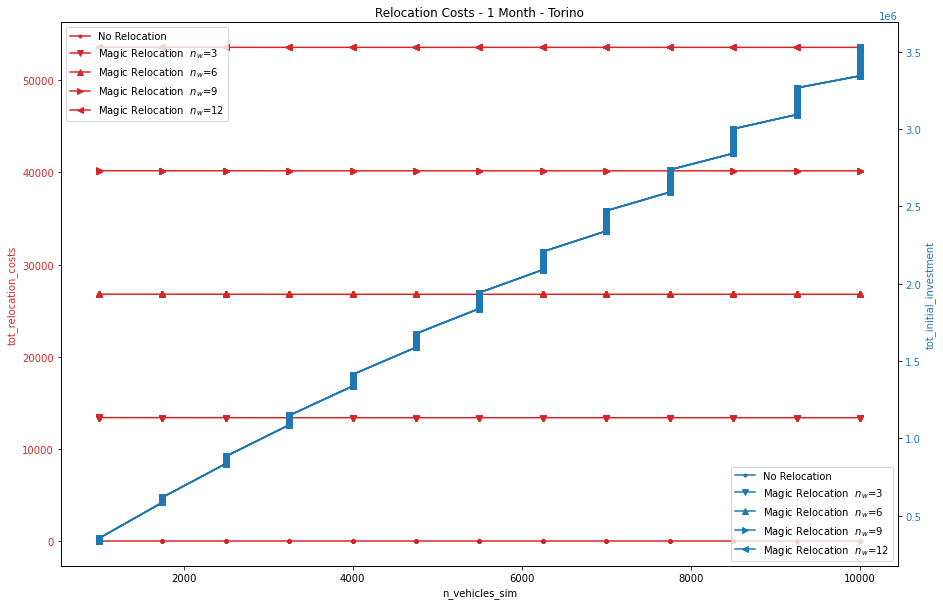

In [10]:
for city in cities:
    plot_df = dict()
    
    plot_df["no_relocation"] = sim_stats_df_dict[city]["no_relocation"][
        sim_stats_df_dict[city]["no_relocation"]["n_relocation_workers"] == 3
    ].set_index("n_vehicles_sim")
    
    fig, ax1 = plt.subplots(figsize=(15,10))
    
    color = 'tab:red'
    plot_df["no_relocation"]["tot_relocation_costs"].plot(ax=ax1, marker='.', color=color, label="No Relocation")
    marker_cycle = itertools.cycle(('v', '^', '>', '<', '1', '2'))
    for n_relocation_workers in range(3, 13, 3):
        marker = next(marker_cycle)
        plot_df["magic_relocation"] = sim_stats_df_dict[city]["magic_relocation"][
            sim_stats_df_dict[city]["magic_relocation"]["n_relocation_workers"] == n_relocation_workers
        ].set_index("n_vehicles_sim")
        plot_df["magic_relocation"]["tot_relocation_costs"].plot(ax=ax1, marker=marker, color=color, label="Magic Relocation "+r" $n_{w}$="+str(n_relocation_workers))
    ax1.set_ylabel("tot_relocation_costs", color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax1.legend(loc=2)

    ax2 = ax1.twinx()

    color = 'tab:blue'
    plot_df["no_relocation"]["tot_initial_investment"].plot(ax=ax2, marker='.', color=color, label="No Relocation")
    marker_cycle = itertools.cycle(('v', '^', '>', '<', '1', '2'))
    for n_relocation_workers in range(3, 13, 3):
        marker = next(marker_cycle)
        plot_df["magic_relocation"] = sim_stats_df_dict[city]["magic_relocation"][
            sim_stats_df_dict[city]["magic_relocation"]["n_relocation_workers"] == n_relocation_workers
        ].set_index("n_vehicles_sim")
        plot_df["magic_relocation"]["tot_initial_investment"].plot(ax=ax2, marker=marker, color=color, label="Magic Relocation "+r" $n_{w}$="+str(n_relocation_workers))
    ax2.set_ylabel("tot_initial_investment", color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    ax2.legend(loc=4)
    
    plt.title("Relocation Costs - 1 Month - " + city)

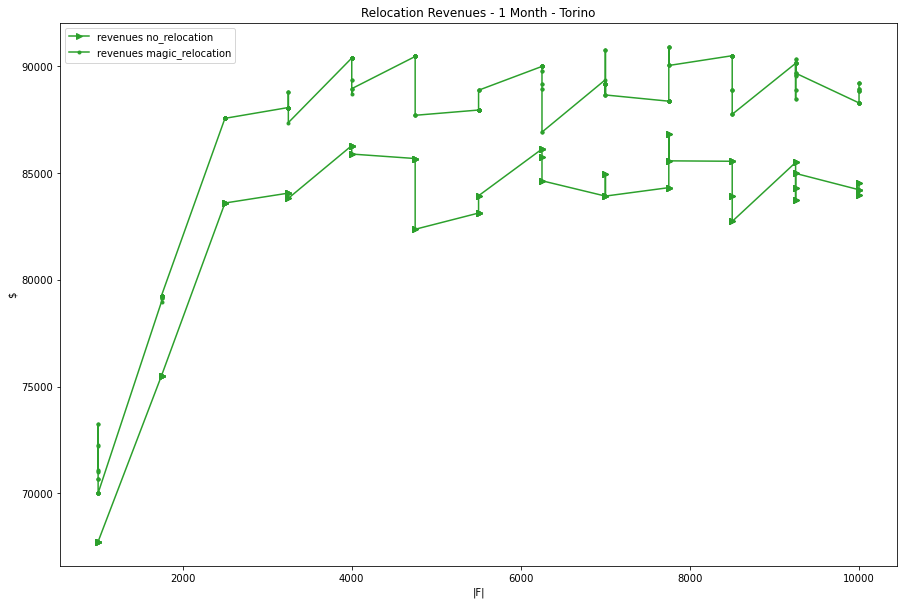

In [11]:
for city in cities:

    fig, ax = plt.subplots(figsize=(15,10))
    marker_cycle = itertools.cycle(('.', 'v', '^', '>', '<', '1', '2'))
        
    for strategy in relocation_strategies:
        for n_relocation_workers in range(3, 13, 3):
            marker = next(marker_cycle)

            plot_df = sim_stats_df_dict[city][strategy][
                sim_stats_df_dict[city][strategy]["n_relocation_workers"] == n_relocation_workers
            ].set_index("n_vehicles_sim")

            # plot_df["tot_relocation_costs"].plot(ax=ax, marker=marker, color='tab:red', label="costs "+strategy+r" $n_{w}$="+str(n_relocation_workers))
            # plot_df["profit_5y_payback"].plot(ax=ax, marker=marker, color='tab:blue', label="profit 5y pb "+strategy+r" $n_{w}$="+str(n_relocation_workers))
            # plot_df["profit_10y_payback"].plot(ax=ax, marker=marker, color='tab:blue', label="profit 10y pb "+strategy+r" $n_{w}$="+str(n_relocation_workers))
        plot_df["tot_revenues"].plot(ax=ax, marker=marker, color='tab:green', label="revenues "+strategy)

    ax.set_xlabel(r"|F|")
    ax.set_ylabel(r"$")

    plt.legend()
    plt.title("Relocation Revenues - 1 Month - " + city)

In [15]:
x_col = "n_vehicles_sim"
y_col = "n_relocation_workers"
z_cols = ["profit_delta_5y_payback", "profit_delta_10y_payback"]

for city in cities:
    for strategy in relocation_strategies:
        if strategy is not "no_relocation":
            for z_col in z_cols:

                df = sim_stats_df_dict[city][strategy][[x_col, y_col, z_col]]

                plot_df = df[[x_col, y_col, z_col]]
                hdfpivot = plot_df.pivot(x_col, y_col)
                X = hdfpivot.columns.levels[1].values
                Y = hdfpivot.index.values
                Z = hdfpivot.values

                Xi,Yi = np.meshgrid(X, Y)
                fig, ax = plt.subplots(figsize=(15, 7))
                if z_cols is "tot_relocation_costs":
                    cs = plt.contourf(Yi, Xi, Z, alpha=0.7, cmap="RdYlGn_r")
                else:
                    cs = plt.contourf(Yi, Xi, Z, alpha=0.7, cmap="RdYlGn")
                cbar = fig.colorbar(cs)
                ax.set_xlabel(r"|F|")
                ax.set_ylabel(r"$n_{w}$")
                plt.title(strategy + ' ' + z_col + " - 1 Month - " + city)


ValueError: Index contains duplicate entries, cannot reshape